# MLSP Homework 5
#### Name: Vijaya Krishna Gopalakrishnan Partha
#### University ID: 2000431429
#### University mail: vgopala@iu.edu

### P1: Neural Network for Source Seperation

#### Importing all required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import librosa as lb
import scipy
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
src_dir = 'M:/Spring 2020/MLSP/HW5/data/data'

#### Loading data

In [3]:
s, sr = lb.load(os.path.join(src_dir, 'trs.wav'), sr = None)
n, sr = lb.load(os.path.join(src_dir, 'trn.wav'), sr = None)

In [4]:
x = s + n

#### Creating DFT matrix 

In [5]:
def dft_matrix(m_size):
    dft_matrix = np.array([[np.exp(-1j * (2 * np.pi * f * n / m_size)) for f in range(0, m_size)] for n in range(0, m_size)])
    return dft_matrix

frame_size = 1024
dft_mat = dft_matrix(1024)
print('The shape of the DFT matrix is: ' + str(dft_mat.shape))

The shape of the DFT matrix is: (1024, 1024)


#### Hanning window on data

In [6]:
def hann_window(raw_data, m_size):
    hann_w = np.hanning(m_size)
    new_data = []
    
    counter = 0
    
    while counter + m_size <= raw_data.shape[0]:
        data_window = np.multiply(raw_data[counter:counter+m_size], hann_w)
        new_data.append(data_window)
        
        counter += int(m_size/2)
    
    new_data_matrix = np.array(new_data).T
    
    return new_data_matrix

#### Creating speech spectrogram

In [7]:
x_hann = hann_window(x, frame_size)
x_stft = np.dot(dft_mat, x_hann)
x_stft = x_stft[0:513,:]
X = np.abs(x_stft)

In [8]:
s_hann = hann_window(s, frame_size)
s_stft = np.dot(dft_mat, s_hann)
s_stft = s_stft[0:513,:]
S = np.abs(s_stft)

In [9]:
n_hann = hann_window(n, frame_size)
n_stft = np.dot(dft_mat, n_hann)
n_stft = n_stft[0:513,:]
N = np.abs(n_stft)

In [10]:
print(X.shape, S.shape, N.shape)

(513, 786) (513, 786) (513, 786)


In [11]:
M = S > N

#### Shallow neural network

In [12]:
def g(x):
    return 1/(1 + np.exp(-x))

In [13]:
def neural_network(hidden_units, max_epochs, X, M):
    num_hidden = hidden_units

    W1 = np.random.randn(num_hidden, X.shape[0])
    b1 = np.random.randn(num_hidden,1)

    W2 = np.random.randn(X.shape[0], num_hidden)
    b2 = np.random.randn(X.shape[0], 1)

    alpha = 0.0002
    M_hat = []
    error_plot = []
    epoch = 0

    while epoch <= max_epochs:

        Z1 = np.dot(W1, X) + b1
        X2 = np.tanh(Z1) 
        
        Z2  = np.dot(W2, X2) + b2
        M_hat = g(Z2)
        
        
        bp_error2 = (M_hat - M) * (M_hat * (1 - M_hat))
        
        deltaw2 = np.dot(bp_error2,X2.T)
        deltab2 = np.dot(bp_error2,np.ones((bp_error2.shape[1],1)))

        W2 = W2 - alpha * deltaw2
        b2 = b2 - alpha * deltab2
        
        bp_error1 = np.dot(W2.T, bp_error2) * (1 - X2**2)

        deltaw1 = np.dot(bp_error1, X.T)
        deltab1 = np.dot(bp_error1, np.ones((bp_error1.shape[1], 1)))

        W1 = W1 - alpha*deltaw1
        b1 = b1 - alpha*deltab1

        error = 0.5 * sum(sum((M_hat-M)**2))
        error_plot.append(error)
        
        epoch += 1
        
    return error_plot, W1, b1, W2, b2

In [14]:
error_plot, W1, b1, W2, b2 = neural_network(50, 5000, X, M)

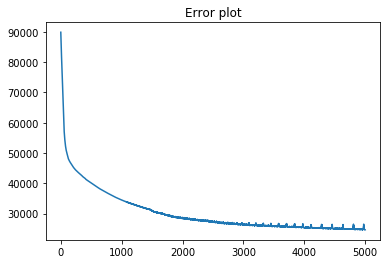

In [15]:
plt.title('Error plot')
plt.plot(error_plot)
plt.show()

#### Loading test data and transforming it

In [16]:
tex, sr = lb.load(os.path.join(src_dir, 'tex.wav'), sr = None)
tes, sr = lb.load(os.path.join(src_dir, 'tes.wav'), sr = None)

In [17]:
tex_hann = hann_window(tex, frame_size)
tex_stft = np.dot(dft_mat, tex_hann)
tex_stft = tex_stft[0:513,:]
test_X = np.abs(tex_stft)

tes_hann = hann_window(tes, frame_size)
tes_stft = np.dot(dft_mat, tes_hann)
tes_stft = tes_stft[0:513,:]
test_S = np.abs(tes_stft)

#### Source seperation on test audio

In [18]:
Z1 = np.dot(W1, test_X) + b1
X2 = np.tanh(Z1)

Z2  = np.dot(W2, X2) + b2
test_M = g(Z2)

In [19]:
recovered_spec = np.multiply(tex_stft, test_M)

#### Creating IDFT matrix

In [20]:
def idft_matrix(m_size):
    
    dft_matrix = np.array([[np.exp(1j * (2 * np.pi * f * n /m_size)) for f in range(0,m_size)] for n in range(0,m_size)])
    idft_matrix = dft_matrix/m_size
    
    return idft_matrix

idft_mat = idft_matrix(frame_size)

print('The shape of the idft matrix is: ' + str(idft_mat.shape))

The shape of the idft matrix is: (1024, 1024)


In [21]:
test_X_conjugate = np.flip(np.conjugate(recovered_spec[1:512, :]), axis = 0)
recovered_speech = np.concatenate((recovered_spec, test_X_conjugate), axis = 0)

In [22]:
recovered_spec = np.dot(idft_mat, recovered_speech)

In [23]:
def reversing_overlap(X, m_size):

    X_out = X[:(X.shape[0] - int(m_size/2)),0]
    
    for col in range(1,X.shape[1]):
        X_col = X[(X.shape[0] - int(m_size/2)):,col-1] + X[0:int(m_size/2),col]
        X_out = np.concatenate((X_out,X_col))

    X_out = X_out.reshape(-1) 

    return X_out

In [24]:
s_hat = reversing_overlap(recovered_spec.real, frame_size)

In [25]:
tes = tes[:s_hat.shape[0]]

#### SNR of test audio

In [26]:
snr = 10 * np.log10(np.dot(tes.T, tes) / np.dot((tes - s_hat).T, (tes - s_hat)))
print('The SNR value is: ' + str(np.round(snr, 3)))

The SNR value is: 4.666


In [27]:
Audio(s_hat, rate = sr)

### Problem 2

In [28]:
Xl = np.array(Image.open(os.path.join(src_dir, 'im0.ppm')))
Xr = np.array(Image.open(os.path.join(src_dir, 'im8.ppm')))

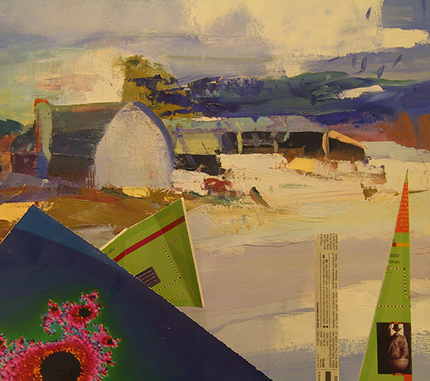

In [29]:
Image.open(os.path.join(src_dir, 'im0.ppm'))

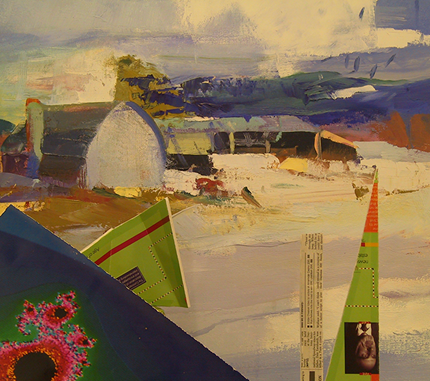

In [30]:
Image.open(os.path.join(src_dir, 'im8.ppm'))

In [31]:
print((Xr.shape))

(381, 430, 3)


#### To find most similar pixel

In [32]:
def similar_pixel(i,j):

    nearest = 0
    dummy_threshold = 1000000

    for k in range(40):
        dist = sum(np.abs(Xr[i,j] - Xl[i,j+k]))

        if dist < dummy_threshold:

            dummy_threshold = dist
            nearest = k

    return nearest

#### Creating disparity map

In [33]:
disparity_map = np.zeros([Xl.shape[0], Xl.shape[1] - 40])

for i in range(disparity_map.shape[0]):
    for j in range(disparity_map.shape[1]):
        disparity_map[i,j] = similar_pixel(i,j)

disparity_vec = disparity_map.reshape(-1,1)

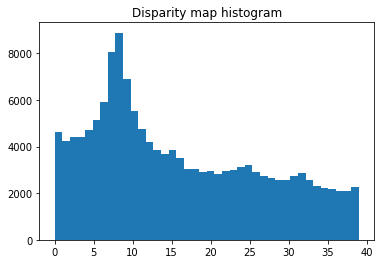

In [34]:
plt.title('Disparity map histogram')
plt.hist(disparity_vec, bins = 40)
plt.show()

In [35]:
def pdf_dist_normal(mu, sigma, x):
    pdf = (1/np.sqrt((2*np.pi*(sigma**2)))) * (np.exp(-(((x-mu)**2)/(2*(sigma**2)))))
    return pdf

#### Clustering using Gaussian Mixture Model

In [36]:
def GMM(data, num_gaussians):

    P_Cluster = np.array([1/num_gaussians]*num_gaussians)
    np.random.seed(50)
    
    cluster_means = np.random.uniform(10, 50, num_gaussians)
    cluster_sds = np.random.uniform(1, 5, num_gaussians)

    probX_given_cluster = np.zeros((np.size(data), num_gaussians))
    U_Cluster = np.zeros((np.size(data), num_gaussians))

    for iter in range(0,500):
        for i in range(num_gaussians):

            probX_given_cluster[:,i] = pdf_dist_normal(cluster_means[i], cluster_sds[i], data).reshape(1,-1)
            probX_given_cluster[probX_given_cluster==0] = 0.00005

        P_X = np.sum(P_Cluster*probX_given_cluster, axis=1)
        U_Cluster = P_Cluster*probX_given_cluster/P_X.reshape(-1,1)

        cluster_means = np.sum(U_Cluster*data.reshape(-1,1), axis = 0)/np.sum(U_Cluster, axis = 0)
        P_Cluster = np.mean(U_Cluster, axis=0)

        for i in range(num_gaussians):
            cluster_sds[i] = np.sqrt(np.sum(U_Cluster[:,i].reshape(-1,1)*((data - cluster_means[i])*\
                      (data - cluster_means[i])))/np.sum(U_Cluster[:,i]))

    membership_matrix = np.argmax(U_Cluster, axis = 1)
    data_frame = pd.DataFrame(data)
    data_frame.columns = ['Disparity Data']
    data_frame['Cluster'] = membership_matrix

    return cluster_means, cluster_sds, data_frame

In [37]:
ClusterMeans, ClusterSDs, data_frame = GMM(disparity_vec, 4)
cluster_map= np.array(data_frame['Cluster'])
depth_map = np.array(data_frame['Cluster'], dtype=float)

for i in range(4):
    depth_map[depth_map == i] = ClusterMeans[i]

depth_map = depth_map.reshape(disparity_map.shape)
cluster_map = cluster_map.reshape(disparity_map.shape)

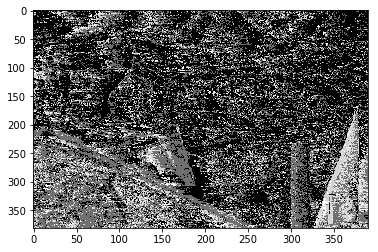

In [38]:
plt.imshow(depth_map,cmap="gray", aspect = 'auto')
plt.show()

#### Gibbs sampling

In [41]:
C = []
smoothened_cluster_map = np.array(cluster_map)
prev_cluster_map = np.array(cluster_map)
smoothened_depth_map = np.zeros(disparity_map.shape)

def similarity(i, j, cluster):
    
    if i < 0 or j < 0 or i > prev_cluster_map.shape[0]-1 or j > prev_cluster_map.shape[1]-1\
        or prev_cluster_map[i,j] == cluster:
        return 1

    a = 5
    sigma = 0.5
    if prev_cluster_map[i,j] == cluster:
        a = 0

    return np.exp(-(a*a/(2*sigma*sigma)))

In [42]:
def prior(i,j,cluster):
    N = [-1,0,1]
    prior_p = 1

    for k in N:
        for l in N:
            prior_p *= similarity(i+k,j+l, cluster)

    return prior_p

In [46]:
for iter in range(30):
    for i in range(disparity_map.shape[0]):
        for j in range(disparity_map.shape[1]):

            current_cluster = cluster_map[i,j]
            posterior = np.zeros(4)

            for k in range(4):
                posterior[k] = pdf_dist_normal(ClusterMeans[k], ClusterSDs[k], depth_map[i,j]) * prior(i,j,k)

            posterior = posterior/np.sum(posterior)
            new_label = np.random.choice(np.arange(0, 4), p=posterior)
            smoothened_depth_map[i,j] = ClusterMeans[new_label]
            smoothened_cluster_map[i,j] = new_label

    C.append(smoothened_depth_map)
    prev_cluster_map = np.array(smoothened_cluster_map)

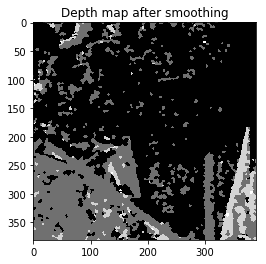

In [52]:
C = np.array(C)
smoothened_final_map = scipy.stats.mode(C[-10:])[0][0]

plt.title('Depth map after smoothing')
plt.imshow(smoothened_final_map,cmap="gray")
plt.show()

### P3: Rock or Metal

In [53]:
trX = scipy.io.loadmat(os.path.join(src_dir, 'trX.mat'))['trX']
trY = scipy.io.loadmat(os.path.join(src_dir, 'trY.mat'))['trY']

In [54]:
print(trX.shape, trY.shape)

(2, 160) (1, 160)


In [57]:
def AdaBoost(num_learners, max_epochs, alpha, trX, trY):
    
    fx = 0
    learner_weights = np.ones((1,trX.shape[1]))
    error_plot_adaboost, learner_weights_list, beta_list = list(), list(), list()
        
    for m in range(num_learners):
    
        W, b = np.random.uniform(-2, 2, (1, 2)), np.random.uniform()
    
        epoch = 0
    
        while epoch <= max_epochs:
            
            Z = np.dot(W, trX) + b
            pred = np.tanh(Z)
        
            backprop_error = -learner_weights * (trY - pred) * (1 - pred**2)
            delta_w = np.dot(backprop_error, trX.T)
            delta_b = np.dot(backprop_error, np.ones_like(trY).T)
        
            W = W - (alpha * delta_w)
            b = b - (alpha * delta_b)
        
            epoch += 1
        
        beta = 0.5 * np.log(np.sum(learner_weights * (np.sign(pred) == trY)) / np.sum(learner_weights * (np.sign(pred) != trY)))
        fx = fx + beta * np.sign(pred)
        error = np.sum(np.sign(fx) != trY)
        learner_weights = learner_weights * np.exp(- beta * trY * np.sign(pred))
    
        error_plot_adaboost.append(error)
        learner_weights_list.append(learner_weights)
        
    return fx, error_plot_adaboost

In [60]:
fx, error_plot_adaboost = AdaBoost(1000, 500, 0.05, trX, trY)

print("Training accuracy using 1000 weak learners is: " + str(np.sum(np.sign(fx) == trY) / trY.shape[1]))

Training accuracy using 1000 weak learners is: 0.8


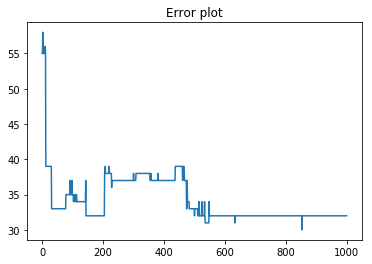

In [61]:
plt.title('Error plot')
plt.plot(error_plot_adaboost)
plt.show()

### P4: PLSI for Analyzing Twitter Stream

In [62]:
twitter = scipy.io.loadmat(os.path.join(src_dir, 'twitter.mat'))

In [63]:
Xtr = twitter['Xtr']
Xte = twitter['Xte']
YtrMat = twitter['YtrMat']
YteMat = twitter['YteMat']

In [64]:
plsi_topics = np.random.randn(891, 50)
plsi_weights = np.random.randn(50, 773)

#### PLSI on training data

In [65]:
for i in range(500):

    den = np.dot(plsi_topics,plsi_weights)
    den[den == 0] = 0.0001

    plsi_topics = plsi_topics * np.dot((Xtr/den), plsi_weights.T)
    plsi_topics = plsi_topics / np.dot(np.ones([plsi_topics.shape[0], plsi_topics.shape[0]]), plsi_topics)

    den = np.dot(plsi_topics,plsi_weights)
    den[den == 0] = 0.0001

    plsi_weights = plsi_weights * np.dot(plsi_topics.T, (Xtr/den))
    plsi_weights = plsi_weights / np.dot(np.ones([plsi_weights.shape[0], plsi_weights.shape[0]]), plsi_weights)

#### PLSI on test data

In [66]:
plsi_weights2 = np.random.rand(50,193)

for i in range(500):

    den = np.dot(plsi_topics, plsi_weights2)
    den[den == 0] = 0.0001

    plsi_weights2 = plsi_weights2 * np.dot(plsi_topics.T, (Xte/den))
    plsi_weights2 = plsi_weights2 / np.dot(np.ones([plsi_weights2.shape[0], plsi_weights2.shape[0]]), plsi_weights2)

#### Perceptron network

In [67]:
alpha = 0.005

W = np.random.uniform(0, 5, (3, plsi_weights.shape[0]))
b = np.random.uniform(0, 5, (3,1))
error_plot = []

for i in range(1000):

    Y_hat = np.exp(np.dot(W, plsi_weights) + b)
    Y_hat = Y_hat / np.sum(Y_hat, axis=0).reshape(1,-1)
    
    error = -np.sum(YtrMat * np.log(Y_hat))

    delta_w = np.dot((Y_hat - YtrMat), plsi_weights.T)
    delta_b = np.dot((Y_hat - YtrMat), np.ones([YtrMat.shape[1],1]))
    
    W = W - (alpha * delta_w)
    b = b - (alpha * delta_b)

    error_plot.append(error)

In [68]:
Z = np.dot(W, plsi_weights2) + b
Y_hat_test = np.exp(Z)

Y_hat_test = Y_hat_test / np.sum(Y_hat_test, axis=0).reshape(1,-1)

train_accuracy = np.sum(np.argmax(Y_hat, axis=0) == np.argmax(YtrMat, axis=0)) / YtrMat.shape[1]
test_accuracy = np.sum(np.argmax(Y_hat_test, axis=0) == np.argmax(YteMat, axis=0)) / YteMat.shape[1]

In [69]:
print('Training accuacy is: ' + str(np.round(train_accuracy, 4)))
print('Testing accuacy is: ' + str(np.round(test_accuracy, 4)))

Training accuacy is: 0.6248
Testing accuacy is: 0.5648


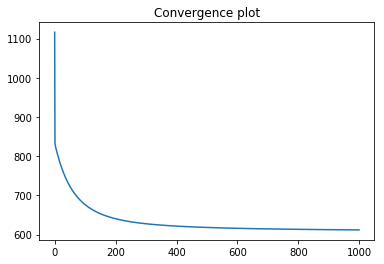

In [70]:
plt.title('Convergence plot')
plt.plot(error_plot)
plt.show()